In [21]:
#import necessary libraries
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import fashion_mnist

In [22]:
#define a performance evaluation function
from sklearn import metrics
def performance_score(input_values, cluster_indexes):
    try:
        silh_score = metrics.silhouette_score(input_values, cluster_indexes)
        print(' .. Silhouette Coefficient score is {:.2f}'.format(silh_score))
        #print( ' ... -1: incorrect, 0: overlapping, +1: highly dense clusts.')
    except:
        print(' .. Warning: could not calculate Silhouette Coefficient score.')
        silh_score = -999

        

    try:
        ch_score =\
         metrics.calinski_harabasz_score(input_values, cluster_indexes)
        print(' .. Calinski-Harabasz Index score is {:.2f}'.format(ch_score))
        #print(' ... Higher the value better the clusters.')
    except:
        print(' .. Warning: could not calculate Calinski-Harabasz Index score.')
        ch_score = -999

    try:
        db_score = metrics.davies_bouldin_score(input_values, cluster_indexes)
        print(' .. Davies-Bouldin Index score is {:.2f}'.format(db_score))
        #print(' ... 0: Lowest possible value, good partitioning.')
    except:
        print(' .. Warning: could not calculate Davies-Bouldin Index score.')
        db_score = -999

    return silh_score, ch_score, db_score


In [23]:
#import the dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# do not forget the validate set
X_train, X_validate, y_train, y_validate =\
 train_test_split(X_train, y_train, test_size=0.1, random_state=1)

#set up a cnn autoencoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D,\
 UpSampling2D, Activation
# Build the autoencoder
model = Sequential()
model.add(Conv2D(14, kernel_size=3, padding='same',\
                 activation='relu', input_shape=(28,28,1)))
model.add(MaxPool2D((2,2), padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(7, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D((2,2), padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(7, kernel_size=3, padding='same', activation='relu'))
model.add(UpSampling2D((2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(14, kernel_size=3, padding='same', activation='relu'))
model.add(UpSampling2D((2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(1, kernel_size=3, padding='same', activation='relu'))

model.compile(optimizer='adam', loss="mse")
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 28, 28, 14)        140       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 14)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 14)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 7)         889       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 7)          0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 7, 7, 7)          

Epoch 1/3
844/844 [==============================] - 30s 35ms/step - loss: 2401.5530 - val_loss: 2038.9305
Epoch 2/3
844/844 [==============================] - 30s 36ms/step - loss: 1655.2592 - val_loss: 1713.0953
Epoch 3/3
313/313 [==============================] - 2s 7ms/step


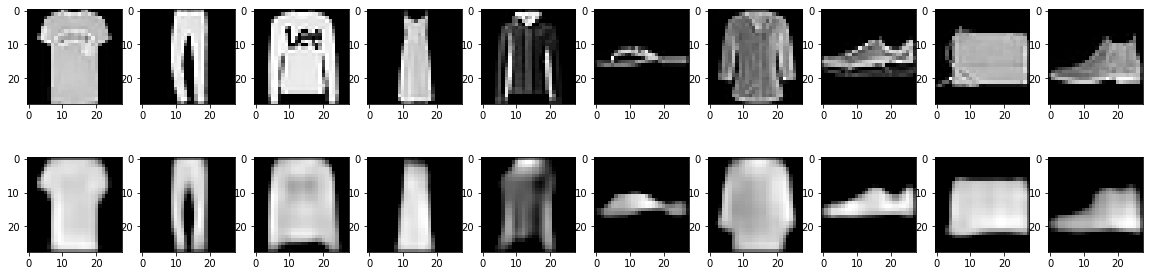

In [24]:
#train the model
model.fit(X_train, X_train, epochs=3, batch_size=64,\
          validation_data=(X_validate, X_validate), verbose=1)

# do some plotting for the reconstructed images
import matplotlib.pyplot as plt
restored_testing_dataset = model.predict(X_test)
# Observe the reconstructed image quality
plt.figure(figsize=(20,5))
for i in range(10):
    index = y_test.tolist().index(i)
    plt.subplot(2, 10, i+1)
    plt.imshow(X_test[index].reshape((28,28)))
    plt.gray()
    plt.subplot(2, 10, i+11)
    plt.imshow(restored_testing_dataset[index].reshape((28,28)))
    plt.gray()

In [25]:
#exctract the encoder block
from keras import backend as K
encoder = K.function([model.layers[0].input],[model.layers[4].output])

#convert images to projected data
test_encoded_images = encoder([X_test])[0].reshape(-1,7*7*7)


In [26]:
#use projections to cluster the images
from sklearn import cluster
for numOfClust in range (3,12):
    print('Currently testing', str(numOfClust),\
        'number of clusters')
    mbkm = cluster.MiniBatchKMeans(n_clusters = numOfClust)
    mbkm.fit(test_encoded_images)
    clusterLabels = mbkm.labels_
    # silh_score = metrics.silhouette_score(outputData.reshape(-1, 1), clusterLabels)
    silh_score, ch_score, db_score = \
    performance_score(y_test.reshape(-1, 1), clusterLabels)

Currently testing 3 number of clusters


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


 .. Silhouette Coefficient score is 0.12
 .. Calinski-Harabasz Index score is 4123.64
 .. Davies-Bouldin Index score is 6.05
Currently testing 4 number of clusters


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


 .. Silhouette Coefficient score is 0.06
 .. Calinski-Harabasz Index score is 3572.93
 .. Davies-Bouldin Index score is 2.19
Currently testing 5 number of clusters


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


 .. Silhouette Coefficient score is 0.01
 .. Calinski-Harabasz Index score is 2730.93
 .. Davies-Bouldin Index score is 4.30
Currently testing 6 number of clusters


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


 .. Silhouette Coefficient score is -0.04
 .. Calinski-Harabasz Index score is 2511.20
 .. Davies-Bouldin Index score is 12.80
Currently testing 7 number of clusters


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


 .. Silhouette Coefficient score is -0.03
 .. Calinski-Harabasz Index score is 2235.11
 .. Davies-Bouldin Index score is 17.34
Currently testing 8 number of clusters


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


 .. Silhouette Coefficient score is -0.05
 .. Calinski-Harabasz Index score is 2135.91
 .. Davies-Bouldin Index score is 28.87
Currently testing 9 number of clusters


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


 .. Silhouette Coefficient score is -0.13
 .. Calinski-Harabasz Index score is 1725.97
 .. Davies-Bouldin Index score is 8.13
Currently testing 10 number of clusters


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


 .. Silhouette Coefficient score is -0.05
 .. Calinski-Harabasz Index score is 1771.57
 .. Davies-Bouldin Index score is 6.37
Currently testing 11 number of clusters


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


 .. Silhouette Coefficient score is -0.02
 .. Calinski-Harabasz Index score is 1705.36
 .. Davies-Bouldin Index score is 14.11


In [29]:
print(test_encoded_images)

[[ 0.81774116  0.15819933  0.         ...  0.          0.
   0.        ]
 [64.59253     0.15819933  0.         ...  0.          8.6891575
   0.        ]
 [ 0.81774116  0.15819933  0.         ...  0.          0.
   0.        ]
 ...
 [ 0.81774116  0.15819933  0.         ...  0.          0.
   0.        ]
 [ 0.81774116  0.15819933  0.         ...  0.          0.
   0.        ]
 [ 0.81774116  0.15819933  0.         ...  0.          0.
   0.        ]]


In [34]:
from sklearn.preprocessing import MinMaxScaler # for feature scaling
scaler= MinMaxScaler()
test_encoded_images_scaled = scaler.fit_transform(test_encoded_images)

In [51]:
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth
clt = MeanShift()
bandwidth = estimate_bandwidth(test_encoded_images, quantile=0.3, n_samples=300)
model = clt.fit(test_encoded_images)

In [61]:
print(np.unique(model.labels_))

[0 1]


In [70]:
import pandas as pd
clusters =model.labels_


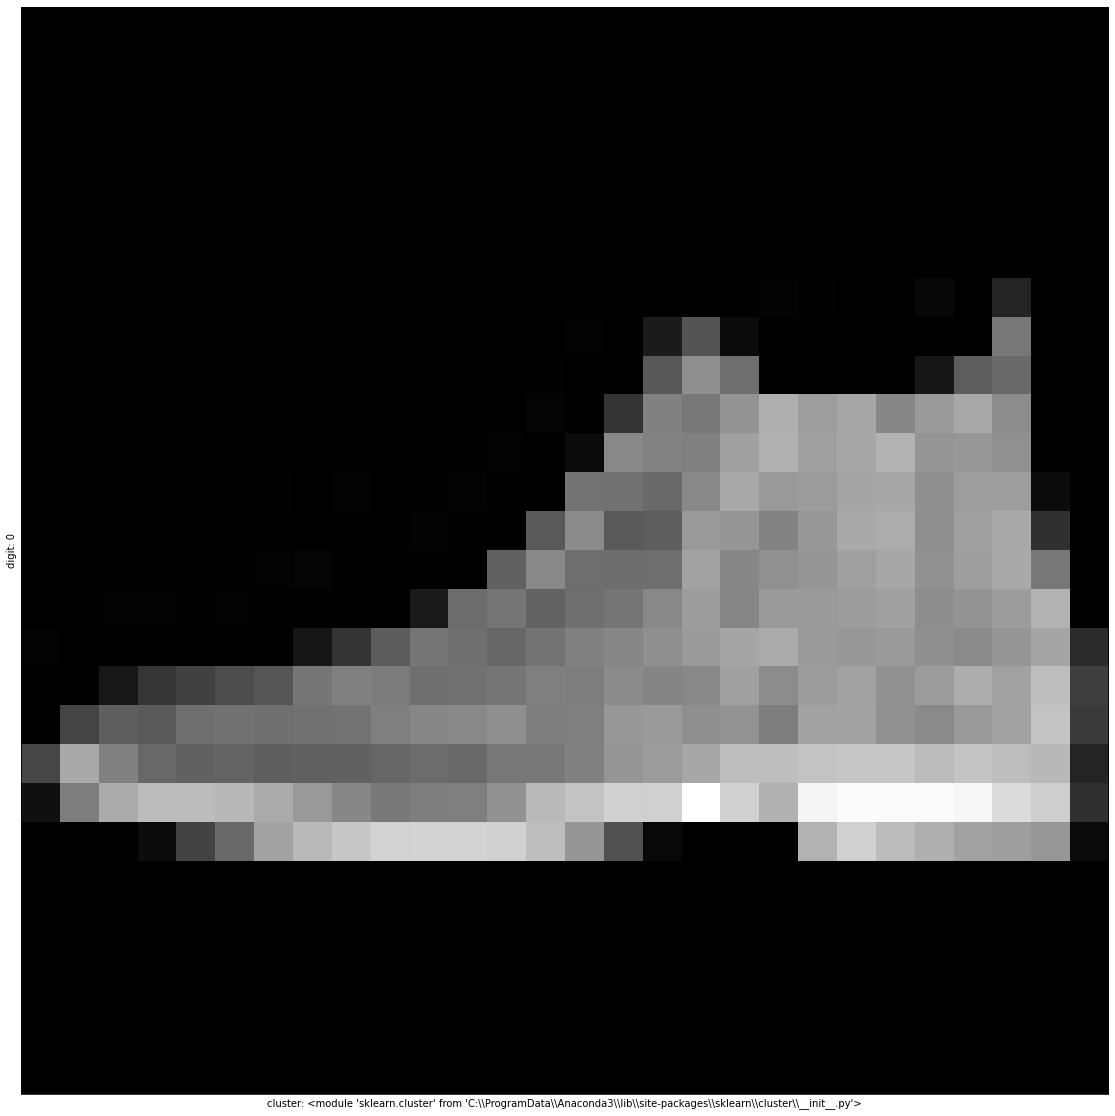

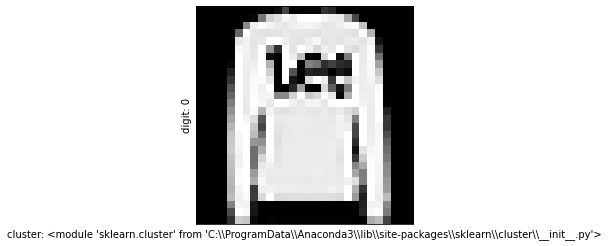

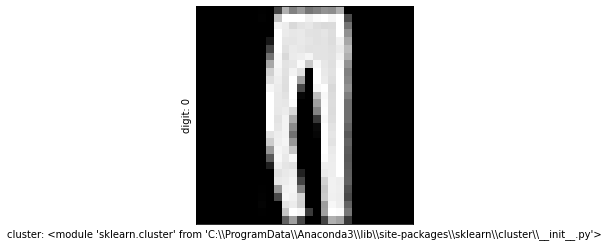

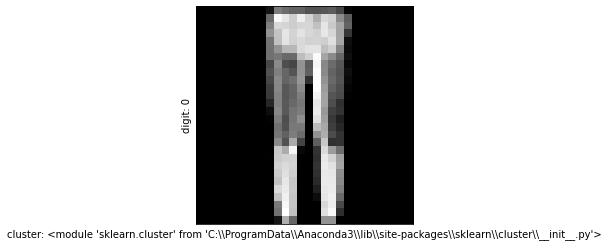

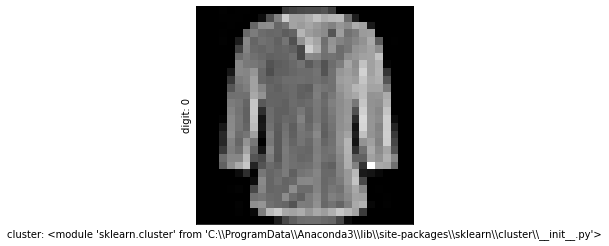

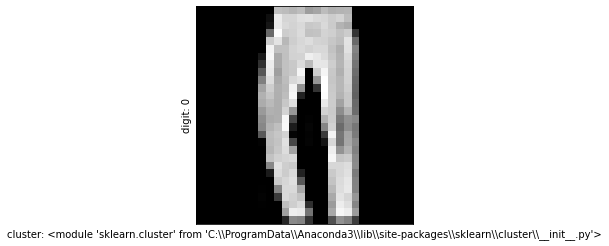

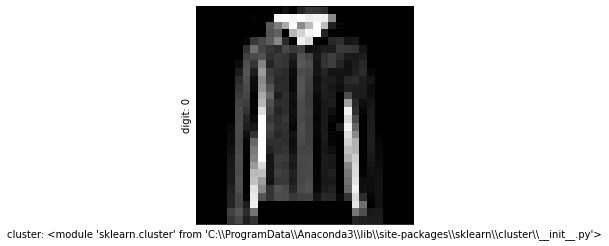

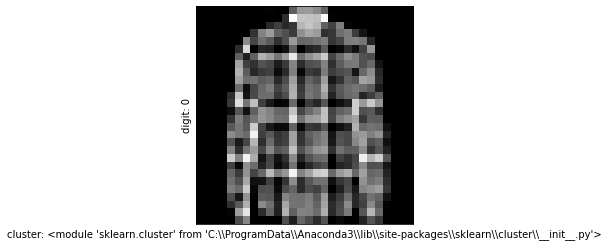

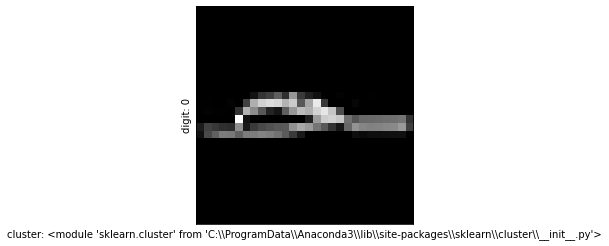

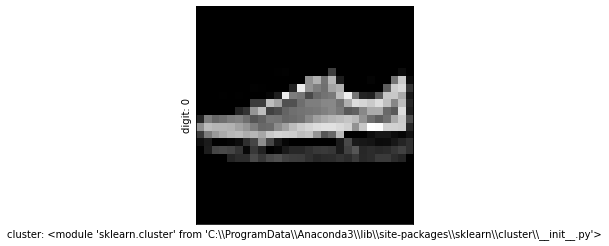

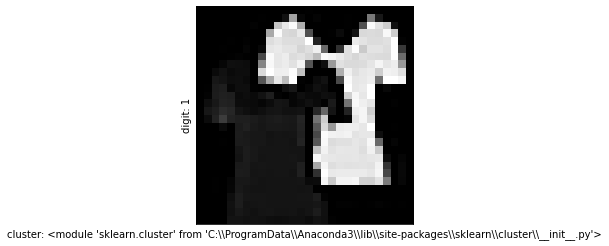

In [77]:
ig = plt.figure(figsize=(20,20))
for clusterIdx in range(10):
    # cluster = cm[r].argmax()
    for c, val in enumerate(X_test[clusters == clusterIdx][0:10]):
        fig.add_subplot(10, 10, 10*clusterIdx+c+1)
        plt.imshow(val.reshape((28,28)))
        plt.gray()
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('cluster: '+str(cluster))
        plt.ylabel('digit: '+str(clusterIdx))
        plt.show()